In [1]:
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
ds_path = "datasets/Intel Image Classification/"
train_path = os.path.join(ds_path, "seg_train")
test_path = os.path.join(ds_path, "seg_test")

classes = os.listdir(train_path)
classes # classes of the dataset

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [4]:
BATCHSIZE = 32
N_WORKERS = 2

In [5]:
from PIL import Image
# check shape of random image
image_path = "datasets/Intel Image Classification/seg_train/buildings/0.jpg"

img = Image.open(image_path)
print(f"Image mode: {img.mode}")
print(f"Image size: {img.size}")

Image mode: RGB
Image size: (150, 150)


In [6]:

# test transformations
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images in case some have wrong size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,), (0.5,))  # Normalize
])

# train transformations(with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,), (0.5,))  # Normalize
])

# Load full training dataset
full_train_ds = datasets.ImageFolder(root=train_path, transform=test_transform)
test_ds = datasets.ImageFolder(root=test_path, transform=test_transform)
# Randomly split dataset
train_ds, val_ds = random_split(full_train_ds, [0.8, 0.2])
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = test_transform

In [7]:
# Create DataLoaders
test_loader = DataLoader(test_ds, batch_size=BATCHSIZE, shuffle=False)
train_loader = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCHSIZE, shuffle=False)

In [8]:
print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 11228, Val size: 2806, Test size: 3000


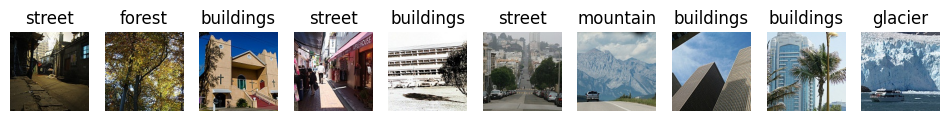

In [9]:
# visualize random samples
load_sample = DataLoader(train_ds, batch_size=10, shuffle=True)
images, labels = next(iter(load_sample))
images = images.permute(0, 2, 3, 1).numpy()

fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
for i, ax in enumerate(axes):
    images[i] = images[i]/2 +0.5
    ax.imshow(images[i])
    ax.set_title(f"{test_ds.classes[labels[i].item()]}")
    ax.axis("off")
plt.show()

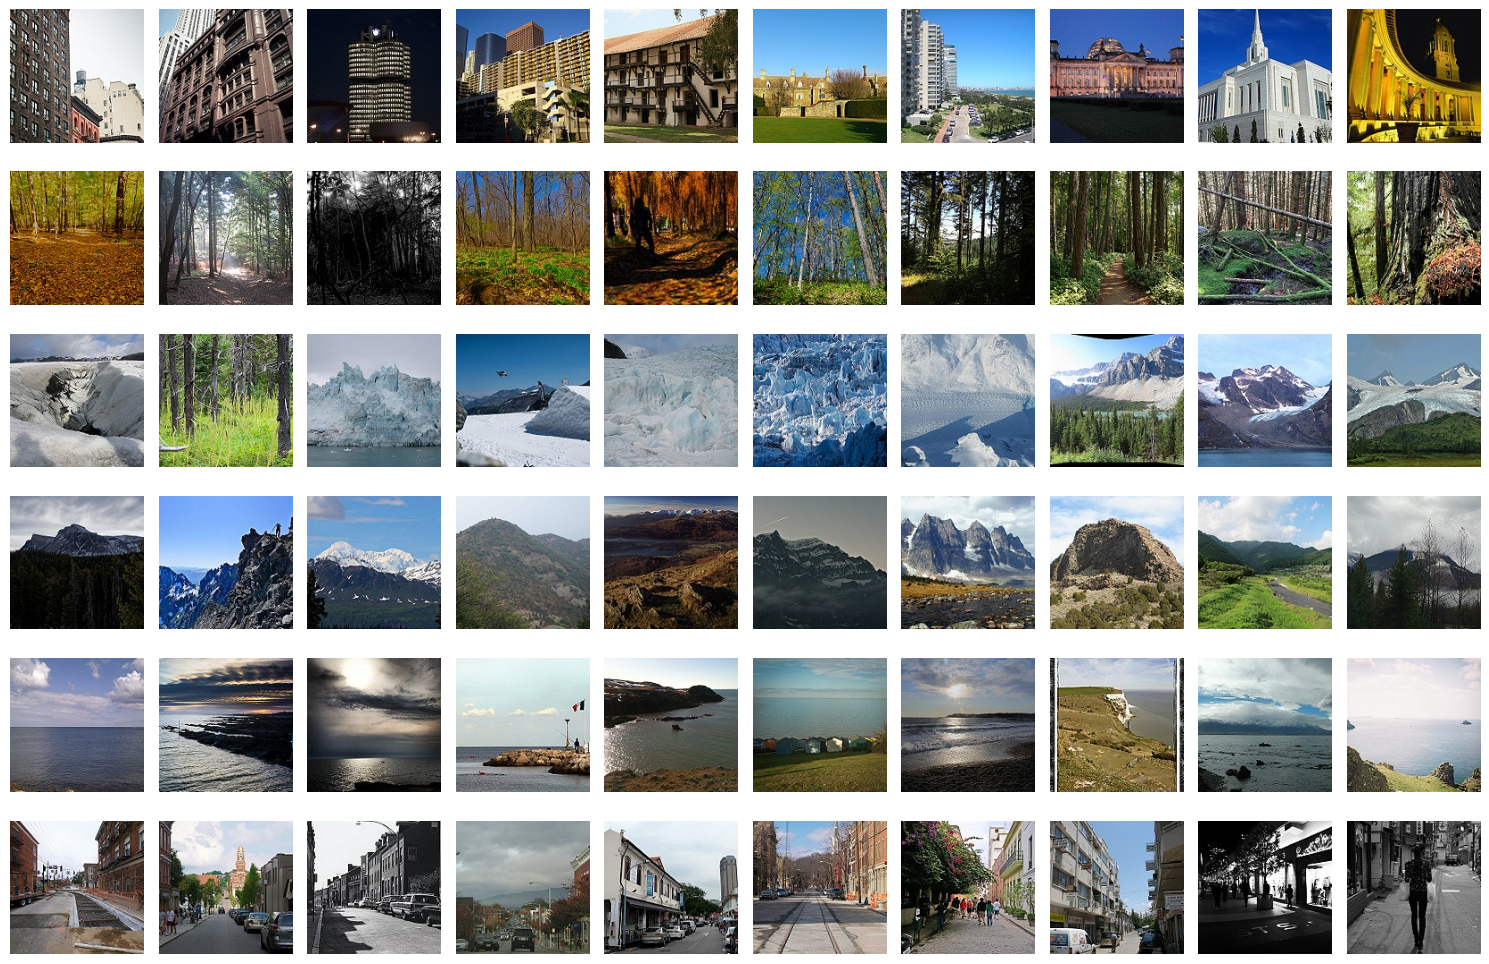

In [10]:
num_classes = len(train_ds.dataset.classes)
samples_per_class = 10  # Number of images per class

# Create dictionary to store images for each class
class_samples = {i: [] for i in range(num_classes)}

# Iterate through DataLoader until we collect enough samples
load_sample = DataLoader(train_ds, batch_size=32, shuffle=True)  # Load in batches
for images, labels in load_sample:
    for img, label in zip(images, labels):
        label = label.item()
        if len(class_samples[label]) < samples_per_class:
            class_samples[label].append(img)

    if all(len(class_samples[i]) == samples_per_class for i in range(num_classes)):
        break

for key in class_samples:
    class_samples[key] = torch.stack(class_samples[key])  
    class_samples[key] = class_samples[key].permute(0, 2, 3, 1).numpy()  

# Create the plot
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 10))

for row in range(num_classes):  
    for col in range(samples_per_class):  
        img = class_samples[row][col] / 2 + 0.5  
        ax = axes[row, col]
        ax.imshow(img)
        if col == 0:
            ax.set_ylabel(train_ds.dataset.classes[row], fontsize=12, weight='bold')  
        ax.axis("off")

plt.tight_layout()
plt.show()


In [11]:
from collections import Counter

# Count occurrences of each class index
train_counts = Counter(label for _, label in train_ds.dataset.samples)
test_counts = Counter(label for _, label in test_ds.samples)

# Print class-wise sample counts
print("Training Set Class Counts:")
for class_idx, count in train_counts.items():
    print(f"{train_ds.dataset.classes[class_idx]}: {count}")

print("\nTest Set Class Counts:")
for class_idx, count in test_counts.items():
    print(f"{test_ds.classes[class_idx]}: {count}")

Training Set Class Counts:
buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382

Test Set Class Counts:
buildings: 437
forest: 474
glacier: 553
mountain: 525
sea: 510
street: 501


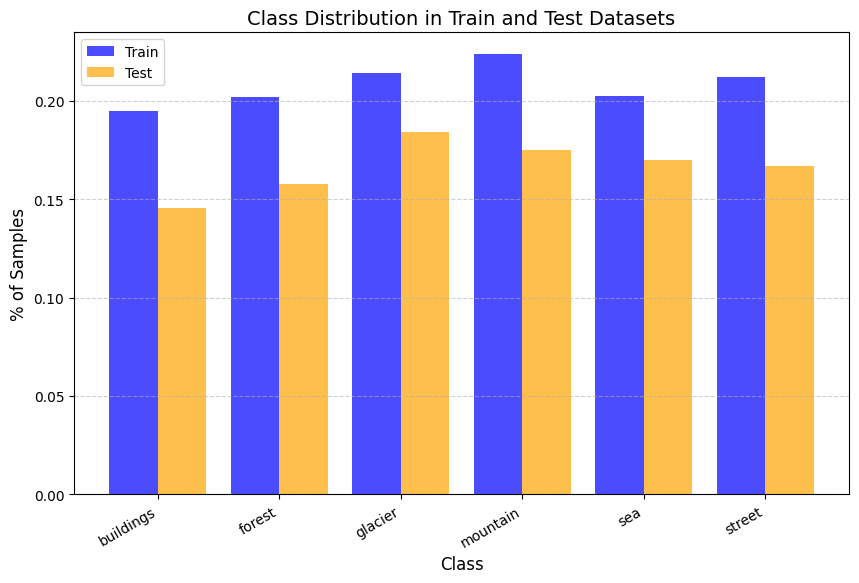

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
x = np.arange(num_classes)

# Plot histogram bars
ax.bar(x - bar_width/2, [count[1]/len(train_ds) for count in train_counts.items()], bar_width, label="Train", color="blue", alpha=0.7)
ax.bar(x + bar_width/2, [count[1]/len(test_ds) for count in test_counts.items()], bar_width, label="Test", color="orange", alpha=0.7)

# Labels and titles
ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("% of Samples", fontsize=12)
ax.set_title("Class Distribution in Train and Test Datasets", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=30, ha="right", fontsize=10)
ax.legend()

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
